# Code Overview: Importing Libraries and Setting Up the Environment

In [ ]:
# Import Standard Libraries
import os
import tarfile
import time
import random
import glob
from PIL import Image
from collections import Counter
from tqdm.auto import tqdm
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Import PyTorch Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from torchvision import datasets
from sklearn.metrics import precision_score, recall_score, f1_score

# Install and Import timm for transformer architecture
!pip install timm -q
import timm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Labeled Data Extraction

In [ ]:
# Define the source and destination folder paths
def extract_all_tar_xz(source_folder_path, destination_folder_path):

    # Iterate through all files in the source folder
    for file_name in os.listdir(source_folder_path):
        if file_name.endswith('.tar.xz'):
            tar_file_path = os.path.join(source_folder_path, file_name)

            print(f"Extracting {file_name} into {destination_folder_path}...")

            # Extract the .tar.xz file directly into the destination folder
            with tarfile.open(tar_file_path, 'r:xz') as tar:
                tar.extractall(path=destination_folder_path)

            print(f"Finished extracting {file_name}.")

    print("All .tar.xz files have been successfully extracted.")

In [ ]:
extract_all_tar_xz('/content/drive/MyDrive/Huron_Labelled_Data', '/content/Labeled_Data')
extract_all_tar_xz('/content/drive/MyDrive/Huron_Labelled_Data_4_Class', '/content/Labeled_Data_4_Class')
extract_all_tar_xz('/content/drive/MyDrive/Huron_Labelled_Data_2_Class', '/content/Labeled_Data_2_Class')

Extracting Preview_Tiles_Ink_Marks.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Ink_Marks.tar.xz.
Extracting Preview_Tiles_Faint_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Faint_Tissue.tar.xz.
Extracting Preview_Tiles_With_No_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_With_No_Tissue.tar.xz.
Extracting Preview_Tiles_Small_Fragmented_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Small_Fragmented_Tissue.tar.xz.
Extracting Preview_Tiles_Large_Solid_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Large_Solid_Tissue.tar.xz.
Extracting Preview_Tiles_With_Some_Faint_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_With_Some_Faint_Tissue.tar.xz.
Extracting Preview_Tiles_Small_One_Piece_Tissue.tar.xz into /content/Labeled_Data...
Finished extracting Preview_Tiles_Small_One_Piece_Tissue.tar.xz.
All .tar.xz files 

# Preparing Labelled Datasets and DataLoaders

In [ ]:
# Function to remove hidden folders
def remove_hidden_folders(folder_path):
    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            if dir_name.startswith('.'):  # Hidden folder detection
                full_path = os.path.join(root, dir_name)
                print(f"Removing hidden folder: {full_path}")
                os.rmdir(full_path)

from collections import defaultdict
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import random

def prepare_balanced_test_set(data_dir, batch_size=32, num_samples_per_class=100):

    remove_hidden_folders(data_dir)

    # Define transformations for preprocessing
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
    ])

    # Load the dataset
    dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

    # Group indices by class
    class_to_indices = defaultdict(list)
    for idx, (_, class_label) in enumerate(dataset):
        class_to_indices[class_label].append(idx)

    # Determine the number of samples to pick from each class
    num_classes = len(class_to_indices)
    samples_per_class = num_samples_per_class // num_classes
    selected_indices = []

    for class_label, indices in class_to_indices.items():
        if len(indices) >= samples_per_class:
            selected_indices.extend(random.sample(indices, samples_per_class))
        else:
            selected_indices.extend(indices)  # Use all samples if insufficient

    # Shuffle selected indices to avoid ordering issues
    random.shuffle(selected_indices)

    # Create the test subset
    test_dataset = Subset(dataset, selected_indices)

    # Create the DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Print class distribution in the test set
    class_counts = defaultdict(int)
    for _, label in test_dataset:
        class_counts[label] += 1
    print("Class distribution in the test set:", dict(class_counts))

    return test_loader, dataset.class_to_idx

def print_batch_info(train_loader):
    for images, labels in train_loader:
        print(f"Batch size: {images.size()}, Labels: {labels}")
        break

In [ ]:
# Prepare datasets and DataLoaders
test_loader_7_Class, class_to_idx_7_Class = prepare_balanced_test_set('/content/Labeled_Data')
print_batch_info(test_loader_7_Class)

test_loader_4_Class, class_to_idx_4_Class = prepare_balanced_test_set('/content/Labeled_Data_4_Class')
print_batch_info(test_loader_4_Class)

test_loader_2_Class, class_to_idx_2_Class = prepare_balanced_test_set('/content/Labeled_Data_2_Class')
print_batch_info(test_loader_2_Class)

Class distribution in the test set: {1: 14, 3: 14, 2: 14, 6: 14, 0: 14, 5: 14, 4: 14}
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([1, 3, 2, 3, 6, 0, 6, 1, 5, 3, 6, 5, 1, 2, 6, 2, 2, 5, 6, 3, 0, 5, 4, 5,
        0, 1, 2, 5, 4, 3, 4, 2])
Class distribution in the test set: {0: 25, 2: 25, 1: 25, 3: 25}
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([0, 2, 1, 2, 0, 2, 2, 1, 2, 1, 3, 1, 1, 0, 2, 1, 0, 2, 3, 0, 1, 2, 0, 3,
        1, 2, 1, 0, 3, 2, 3, 3])
Class distribution in the test set: {0: 50, 1: 50}
Batch size: torch.Size([32, 3, 224, 224]), Labels: tensor([0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 1, 0, 0, 1, 1, 0, 1])


#Class to Index Preview

In [21]:
print(class_to_idx_7_Class)
print(class_to_idx_4_Class)
print(class_to_idx_2_Class)

{'Preview Tiles Small Fragmented tissue': 0, 'Preview Tiles Small One Piece Tissue': 1, 'Preview Tiles with No Tissue': 2, 'Preview Tiles with Some Faint Tissue': 3, 'Preview Tiles_Faint Tissue': 4, 'Preview Tiles_Ink Marks': 5, 'Preview Tiles_Large Solid Tissue': 6}
{'Preview Tiles Small Fragmented tissue': 0, 'Preview Tiles with No Tissue': 1, 'Preview Tiles_Ink Marks': 2, 'Preview Tiles_Large Solid Tissue': 3}
{'Preview Tiles with Some Faint Tissue': 0, 'Preview Tiles_Faint Tissue': 1}


#Load model and classification head

In [ ]:
# Define parameters
def intialize_model(checkpoint_path, num_classes, device):

    # Load the checkpoint
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Load the pre-trained backbone
        backbone = timm.create_model('vit_tiny_patch16_224', pretrained=True)

        # Recreate the model architecture to match the saved checkpoint
        in_dim = backbone.head.in_features

        classification_head = nn.Sequential(
            nn.Linear(in_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

        # Use the saved classification head
        backbone.head = classification_head
        backbone = backbone.to(device)

        # Load the saved state dict
        backbone.load_state_dict(checkpoint['model_state_dict'], strict=True)
        print(f"Model loaded successfully with the saved head from {checkpoint_path}")
    else:
        print(f"Checkpoint not found at {checkpoint_path}. Starting with a fresh model.")

    # Test the loaded model with dummy data
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    output = backbone(dummy_input)
    print("Output shape:", output.shape)  # Should match [1, num_classes]

    return backbone

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone_7_class = intialize_model('/content/checkpoints/final_model_tiny_7_Class.pth', 7, device)
backbone_4_class = intialize_model('/content/checkpoints/final_model_tiny_4_Class.pth', 4, device)
backbone_2_class = intialize_model('/content/checkpoints/final_model_tiny_2_Class.pth', 2, device)

Loading checkpoint from: /content/checkpoints/final_model_tiny_7_Class.pth


<ipython-input-13-e16351696cd9>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.10/dist

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Model loaded successfully with the saved head from /content/checkpoints/final_model_tiny_7_Class.pth
Output shape: torch.Size([1, 7])
Loading checkpoint from: /content/checkpoints/final_model_tiny_4_Class.pth
Model loaded successfully with the saved head from /content/checkpoints/final_model_tiny_4_Class.pth
Output shape: torch.Size([1, 4])
Loading checkpoint from: /content/checkpoints/final_model_tiny_2_Class.pth
Model loaded successfully with the saved head from /content/checkpoints/final_model_tiny_2_Class.pth
Output shape: torch.Size([1, 2])


#Class weights for criterion

In [ ]:
# Calculate class weights for imbalanced datasets
def get_class_weights(train_loader):
    class_counts = Counter([label for _, label in train_loader.dataset])
    class_weights = [1.0 / class_counts[c] for c in range(len(class_counts))]
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Convert class weights to a tensor
    class_weights = torch.tensor([class_weights[i] for i in range(len(class_counts))], dtype=torch.float).to(device)

    # Output the class counts
    print("Class Counts:", class_counts)
    print("Class Weights:", class_weights)

    return class_weights

#Validate model on test set

In [ ]:
def validate_model(backbone, test_loader, device, class_weights, num_classes):

    backbone.eval()
    total_valid_loss = 0
    correct_valid = 0
    total_valid = 0

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(backbone.head.parameters(), lr=0.001, weight_decay=1e-5)

    all_valid_labels = []
    all_valid_predictions = []
    huron_tiny_7_classes_metrics = {}

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = backbone(images)
            loss = criterion(outputs, labels)

            # Track validation loss and accuracy
            total_valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == labels).sum().item()
            total_valid += labels.size(0)

            # Store predictions and labels for metrics
            all_valid_labels.extend(labels.cpu().numpy())
            all_valid_predictions.extend(predicted.cpu().numpy())

    valid_loss = total_valid_loss / len(test_loader)
    valid_accuracy = correct_valid / total_valid * 100
    valid_precision = precision_score(all_valid_labels, all_valid_predictions, average='weighted')
    valid_recall = recall_score(all_valid_labels, all_valid_predictions, average='weighted')
    valid_f1 = f1_score(all_valid_labels, all_valid_predictions, average='weighted')

    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_valid_labels, all_valid_predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    metric_dict = {
        'model_name': f'Huron Tiny {num_classes} Classes',
        'valid_accuracy': valid_accuracy,
        'valid_precision': valid_precision,
        'valid_recall': valid_recall,
        'valid_f1': valid_f1
    }

    print("Final Metrics:", metric_dict)

    return metric_dict

Class Counts: Counter({1: 14, 3: 14, 2: 14, 6: 14, 0: 14, 5: 14, 4: 14})
Class Weights: tensor([0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714, 0.0714])


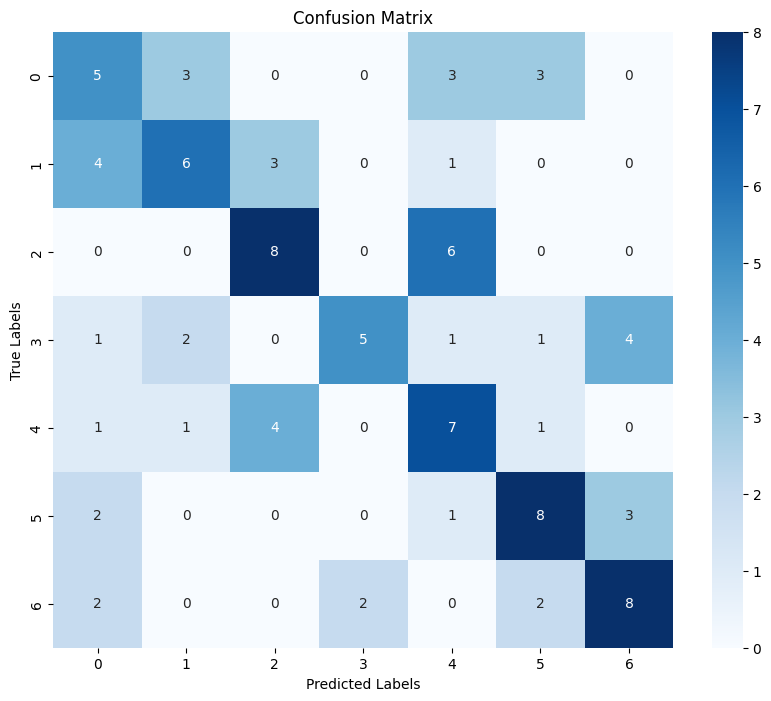

Final Metrics: {'model_name': 'Huron Tiny 7 Classes', 'valid_accuracy': 47.95918367346938, 'valid_precision': 0.5022914428929467, 'valid_recall': 0.47959183673469385, 'valid_f1': 0.480281623138766}


In [ ]:
huron_tiny_7_classes_metrics = validate_model(backbone_7_class, test_loader_7_Class, device, get_class_weights(test_loader_7_Class), 7)

Class Counts: Counter({0: 25, 2: 25, 1: 25, 3: 25})
Class Weights: tensor([0.0400, 0.0400, 0.0400, 0.0400])


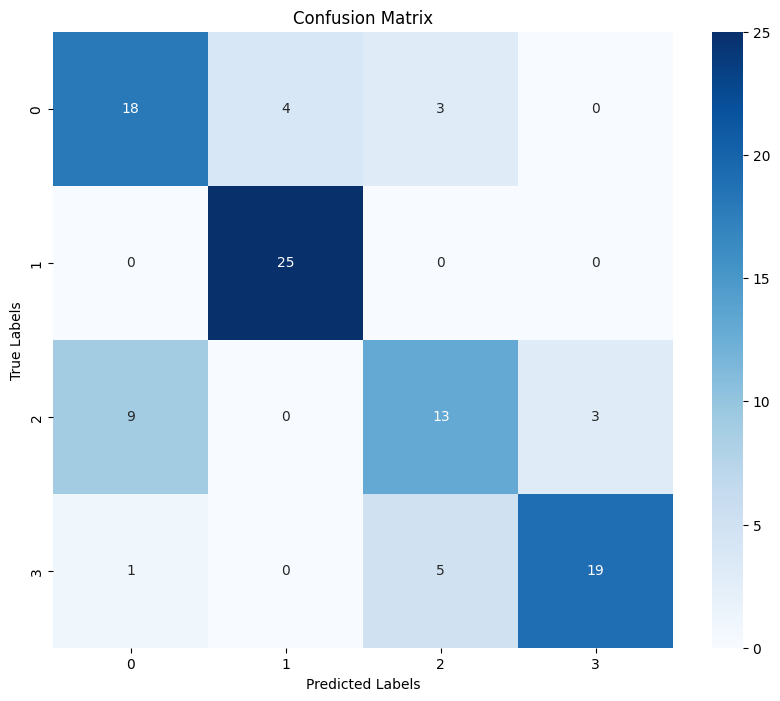

Final Metrics: {'model_name': 'Huron Tiny 4 Classes', 'valid_accuracy': 75.0, 'valid_precision': 0.7469025227645916, 'valid_recall': 0.75, 'valid_f1': 0.7447248096367534}


In [ ]:
huron_tiny_4_classes_metrics = validate_model(backbone_4_class, test_loader_4_Class, device, get_class_weights(test_loader_4_Class), 4)

Class Counts: Counter({0: 50, 1: 50})
Class Weights: tensor([0.0200, 0.0200])


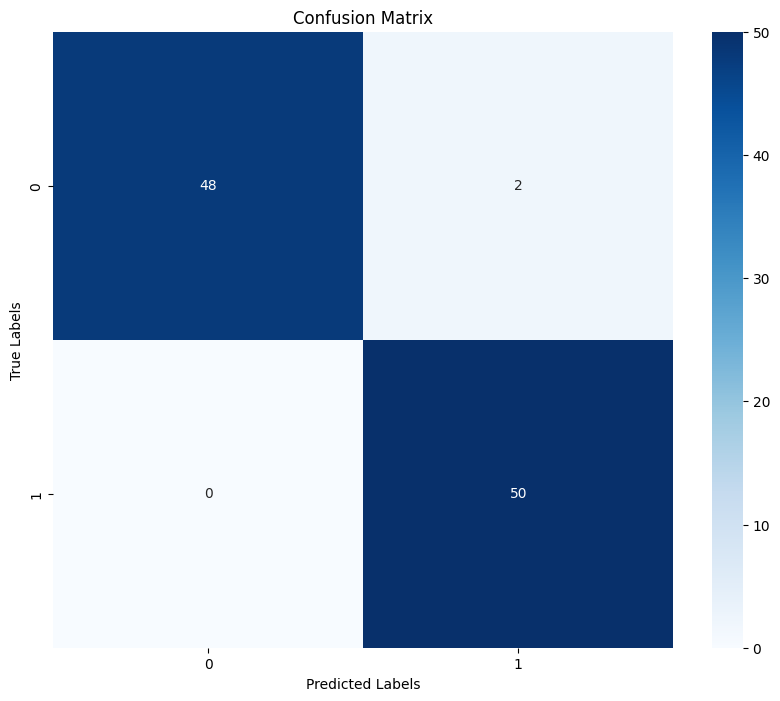

Final Metrics: {'model_name': 'Huron Tiny 2 Classes', 'valid_accuracy': 98.0, 'valid_precision': 0.9807692307692308, 'valid_recall': 0.98, 'valid_f1': 0.9799919967987194}


In [ ]:
huron_tiny_2_classes_metrics = validate_model(backbone_2_class, test_loader_2_Class, device, get_class_weights(test_loader_2_Class), 2)

#Download metrics as excel sheet

In [ ]:
# Combine dictionaries into a list
all_metrics = [huron_tiny_7_classes_metrics, huron_tiny_4_classes_metrics, huron_tiny_2_classes_metrics]

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(all_metrics)

# Display the table
print("\nMetrics Table:")
print(df)

# Save the DataFrame as an Excel fil
output_file = 'model_metrics.xlsx'
df.to_excel(output_file, index=False)


Metrics Table:
             model_name  valid_accuracy  valid_precision  valid_recall  \
0  Huron Tiny 7 Classes       47.959184         0.502291      0.479592   
1  Huron Tiny 4 Classes       75.000000         0.746903      0.750000   
2  Huron Tiny 2 Classes       98.000000         0.980769      0.980000   

   valid_f1  
0  0.480282  
1  0.744725  
2  0.979992  
